In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.layers import Dropout

In [17]:
# Unzip the dataset
!unzip garbageClassification.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardb

In [18]:

train_dir = os.path.join('Garbage classification/Garbage classification')
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [19]:
# Number of images for each class in the dataset
for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "cardboard":	 403
Images of label "glass":	 501
Images of label "metal":	 410
Images of label "paper":	 594
Images of label "plastic":	 482
Images of label "trash":	 137


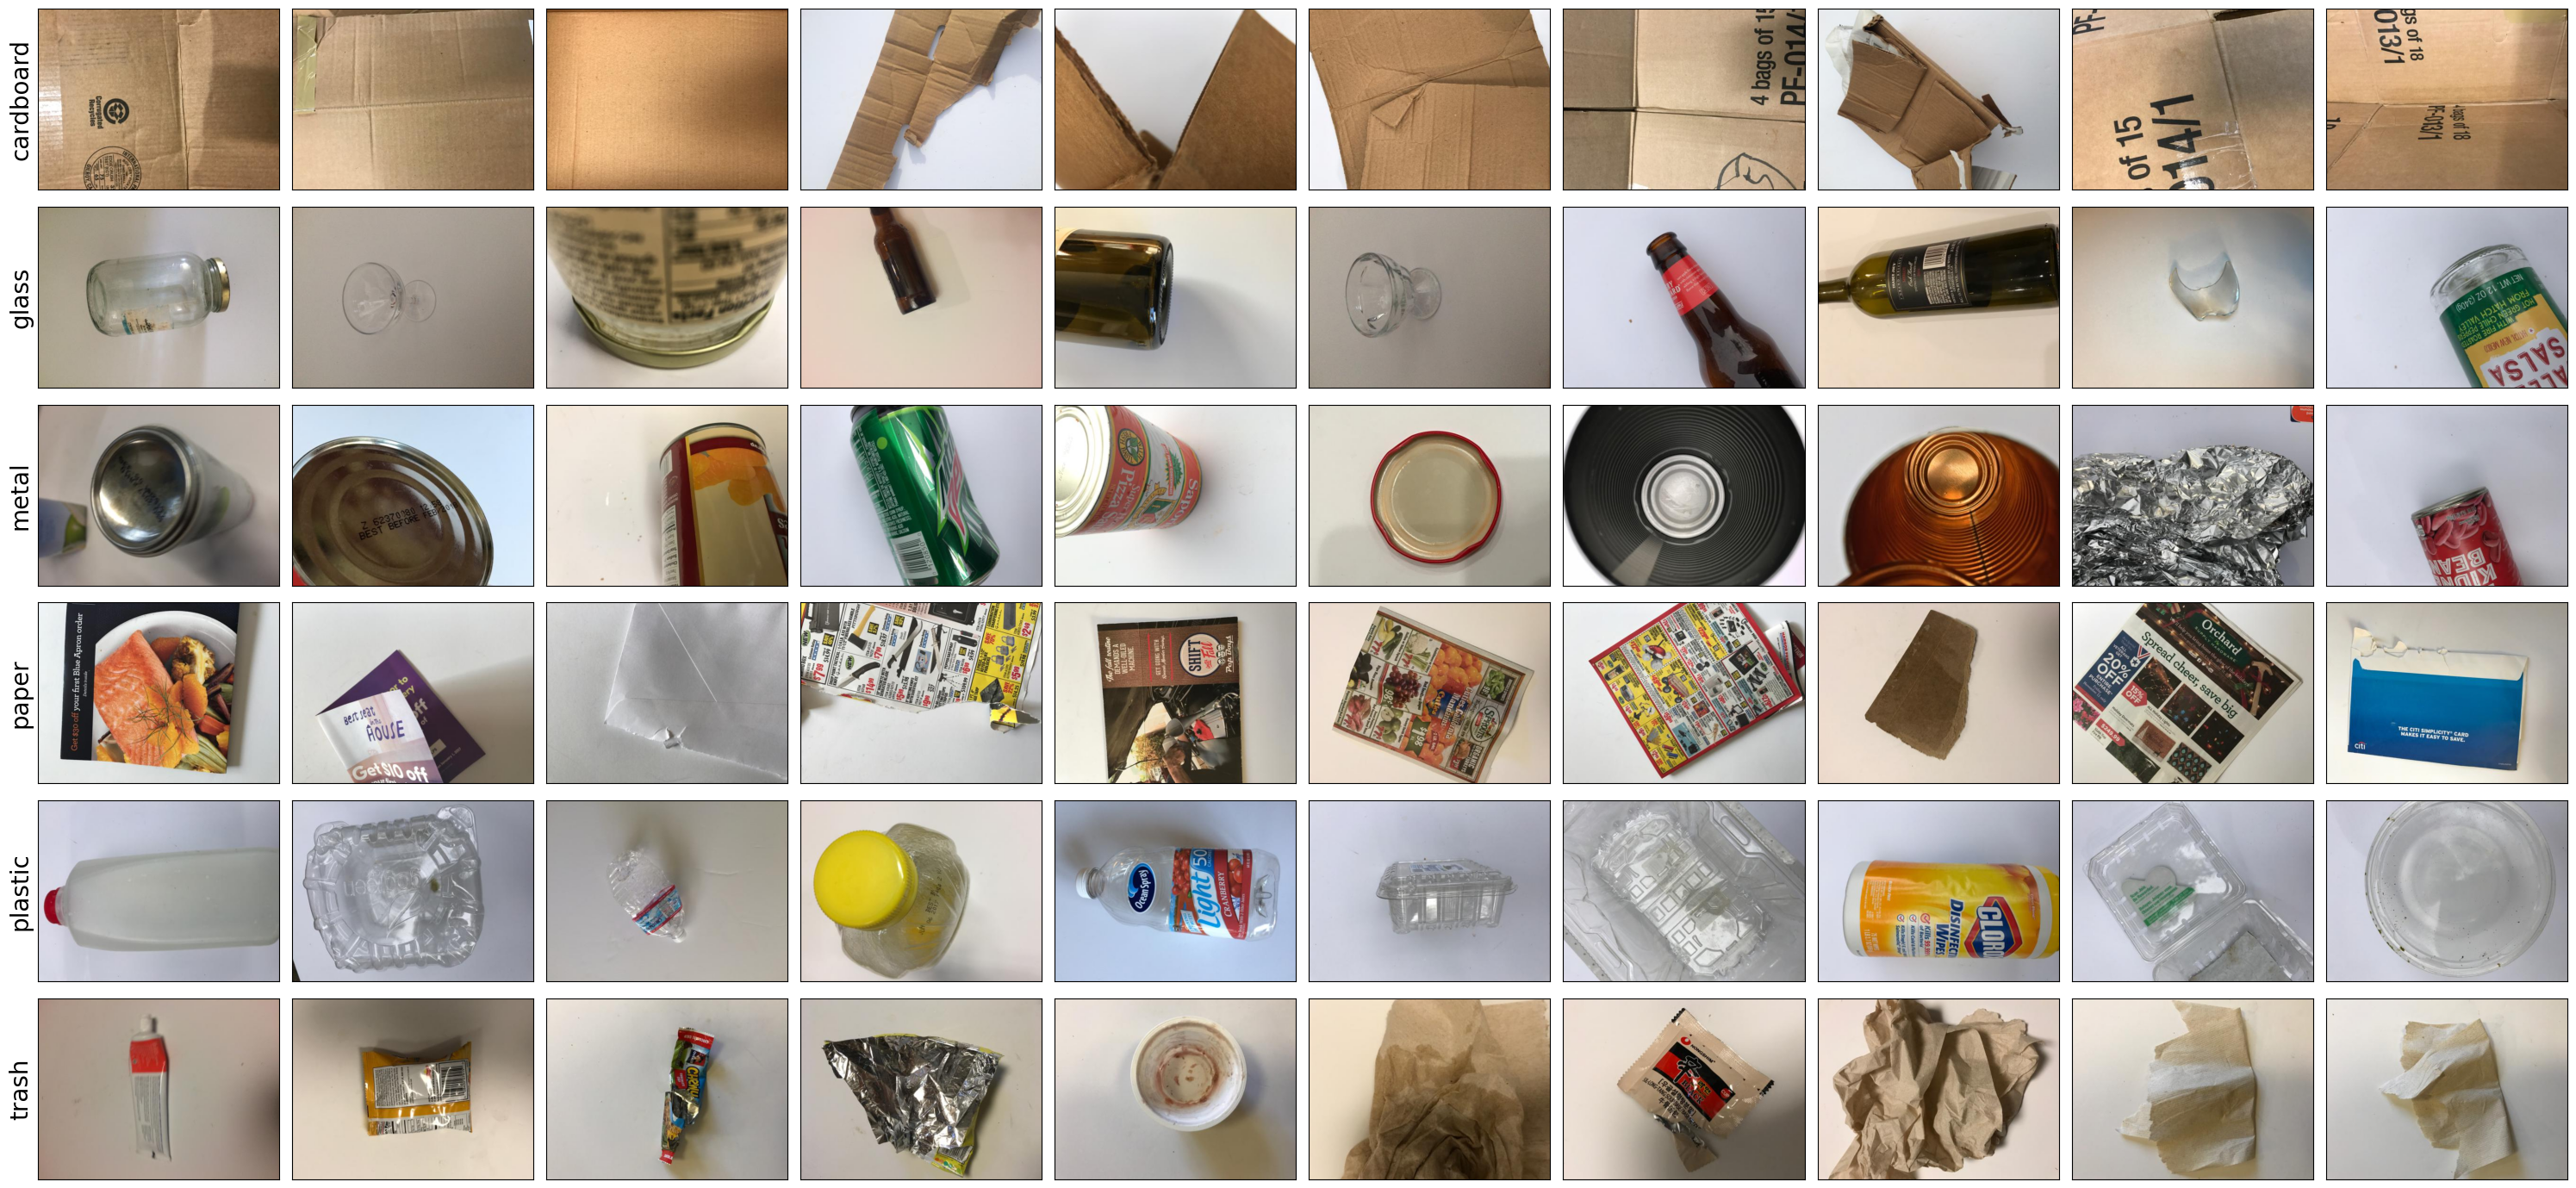

In [20]:
# Sample images from different classes in the dataset
plt.figure(figsize=(30,14))

for i in range(6):
    directory = os.path.join(train_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)

        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)

        if j == 0:
            plt.ylabel(labels[i], fontsize=20)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.tight_layout()
plt.show()

In [21]:
# Checking image dimensions
directory = os.path.join(train_dir, 'cardboard')
path = os.path.join(directory, os.listdir(directory)[0])
image = mpimg.imread(path)
image.shape

(384, 512, 3)

In [22]:
# Creating the CNN model

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l1_l2(0.01),bias_regularizer=l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l1_l2(0.01),bias_regularizer=l2(0.01)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                        

In [23]:
# Compiling the model with loss function, optimizer, and evaluation metric
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(lr = 0.0001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
# Data preprocessing steps

train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255.,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128,128 ), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='binary', subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [25]:
# Early stopping function is defined, and the patience value is set
earlystopCB = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=9)


In [26]:
# Training the model using the fit() function
history = model.fit(train_generator, epochs=100, verbose=1, validation_data=validation_generator, callbacks=[earlystopCB],batch_size=16)

Epoch 1/100
64/64 [==============================] - 124s 2s/step - loss: 13.4137 - accuracy: 0.2495 - val_loss: 12.8183 - val_accuracy: 0.1590
Epoch 2/100
64/64 [==============================] - 119s 2s/step - loss: 12.9424 - accuracy: 0.3325 - val_loss: 12.8458 - val_accuracy: 0.1710
Epoch 3/100
64/64 [==============================] - 120s 2s/step - loss: 12.6567 - accuracy: 0.3715 - val_loss: 12.9311 - val_accuracy: 0.2644
Epoch 4/100
64/64 [==============================] - 121s 2s/step - loss: 12.4426 - accuracy: 0.4249 - val_loss: 13.1265 - val_accuracy: 0.2863
Epoch 5/100
64/64 [==============================] - 119s 2s/step - loss: 12.2105 - accuracy: 0.4452 - val_loss: 13.0087 - val_accuracy: 0.2823
Epoch 6/100
64/64 [==============================] - 117s 2s/step - loss: 12.0260 - accuracy: 0.4605 - val_loss: 12.9385 - val_accuracy: 0.3062
Epoch 7/100
64/64 [==============================] - 117s 2s/step - loss: 11.8223 - accuracy: 0.4847 - val_loss: 12.7067 - val_accuracy:

[Text(0.5, 0, 'Epochs')]

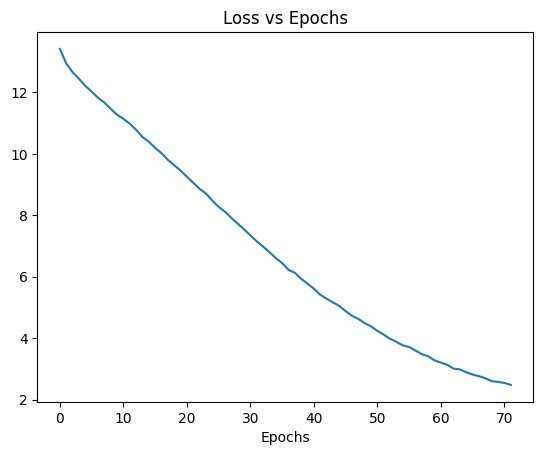

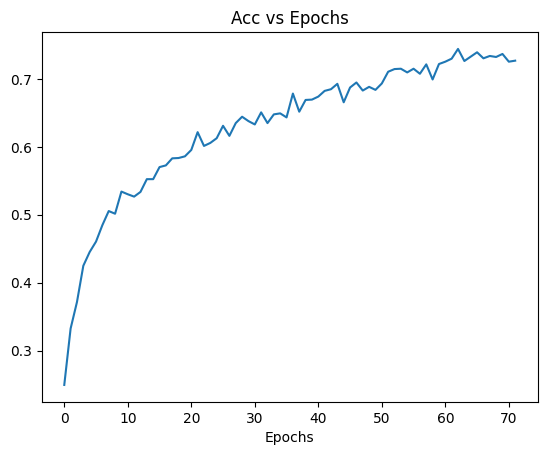

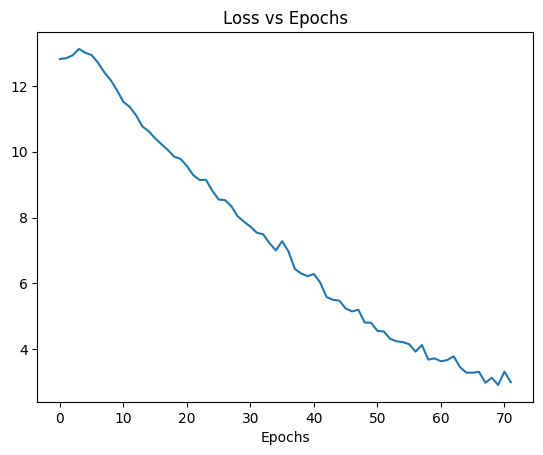

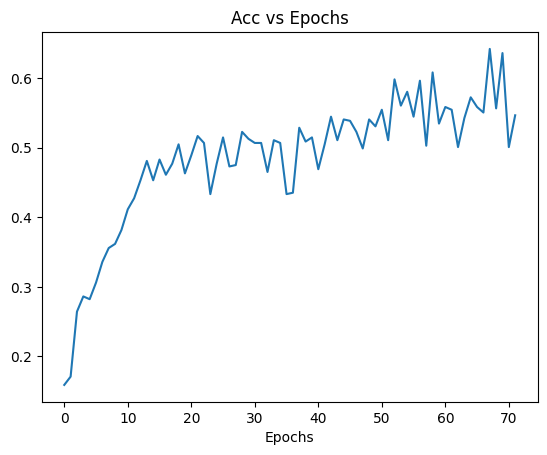

In [29]:
# Creating and plotting training and validation loss and accuracy curves
df = pd.DataFrame(history.history)
df.head()
loss_plot = df.plot(y = 'loss' , title = 'Loss vs Epochs', legend= False)
loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'accuracy' , title = 'Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

loss_plot = df.plot(y = 'val_loss' , title = 'Loss vs Epochs', legend= False)
loss_plot.set(xlabel='Epochs')

acc_plot = df.plot(y = 'val_accuracy' , title = 'Acc vs Epochs', legend= False)
acc_plot.set(xlabel='Epochs')

In [30]:
# Testing the model

test_loss,test_acc = model.evaluate(validation_generator,verbose=1)


16/16 [==============================] - 10s 581ms/step - loss: 3.0074 - accuracy: 0.5368
